In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, CalibrationSystemNoMiniBatch, EQ, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simple Scaling Demo

Just two sensors, the low-cost sensor varies between 50% and 150% of the true sensor.
The latent function models the log scaling of the low-cost sensor.

In [13]:
X = np.c_[np.linspace(0,20,2001),np.zeros(2001),np.ones(2001)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y*(0.5+0.1*X[:,0])]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [23]:
def transform_fn(samps,Y):
    return Y*tf.exp(samps[:,:,0:1])

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=0.01,lr=0.05,minibatchsize=20)
#cs = CalibrationSystemNoMiniBatch(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=0.01,lr=0.05)
import time
st = time.time()
elbo_record = cs.run(its=200)
print(time.time()-st)

Starting Run
20 (ELBO=1879616256.0000)
40 (ELBO=1003366272.0000)
60 (ELBO=119830680.0000)
80 (ELBO=69566760.0000)
100 (ELBO=49180948.0000)
120 (ELBO=40752192.0000)
140 (ELBO=50585472.0000)
160 (ELBO=34766228.0000)
180 (ELBO=39627144.0000)
200 (ELBO=36142900.0000)
5.810340881347656


(0, 300000000)

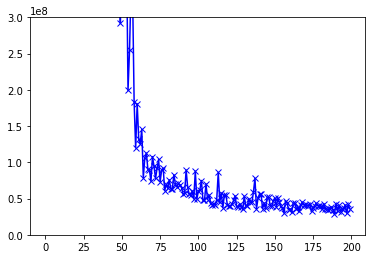

In [26]:
plt.plot(elbo_record,'b-x')
plt.ylim([0,300000000])

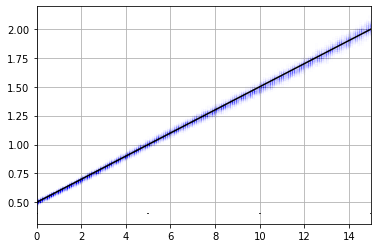

In [25]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,1/tf.exp(samps[:,:,0].numpy().T),'b.',alpha=0.0025);
    plt.grid()
    plt.vlines(Z[:,0],.4,.41)
    plt.xlim([0,15])
    #plt.hlines(0.5,0,15,'k',label='scale')
    plt.plot([0,15],[0.5+0,0.5+0.1*15],'k-')
    #plt.legend(loc='lower left')

## Likelihood Model Demo

Here we have two sensors (reference and a permanently colocated static sensor). We add varying amounts of noise to the 2nd sensor. This is handled by the model.

In this example we use a different transform_fn that arguably isn't as sensible, with a scaling of 1+latent function. This clearly has issues as it allows negative scalings and treats an increase of 1.5x as equivalent in magnitude to a decrease of x0.5. While in reality one would expect 2x and 0.5x to be equivalent.

In [40]:
N = 501
X = np.linspace(0,260,N)[:,None]
X = np.c_[X,np.zeros(N),np.ones(N)]
Y = np.c_[np.linspace(20,40,N)[:,None],np.linspace(40,80,N)[:,None]]
Y[:,1]*=np.cos(X[:,0]/10)*0.2+1
Y[50:70,1]+=np.random.randn(20)*np.linspace(0,10,20)
Y[70:90,1]+=np.random.randn(20)*np.linspace(10,0,20)
Y[200:250,1]+=np.random.randn(50)*np.linspace(0,30,50)
Y[250:300,1]+=np.random.randn(50)*np.linspace(30,0,50)
Y[:,1]+=np.random.randn(N)*np.linspace(3,0,N)
refsensor = np.array([1,0])
Z = np.linspace(0,260,50)[:,None]

In [41]:
def transform_fn(samps,Y):
    return Y*(1+samps[:,:,0:1])

In [44]:
k = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
klike = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, k, likemodel='distribution',gpflowkernellike=klike,likelihoodstd=0.5,minibatchsize=120)
import time
before = time.time()
elbo_record = cs.run(1000)
print(time.time()-before)

Starting Run
20 (ELBO=84955.0391)
40 (ELBO=32931.6094)
60 (ELBO=17510.3633)
80 (ELBO=10125.9355)
100 (ELBO=7499.6431)
120 (ELBO=4798.7349)
140 (ELBO=4124.7617)
160 (ELBO=3721.7014)
180 (ELBO=2865.9707)
200 (ELBO=2578.2686)
220 (ELBO=2205.5291)
240 (ELBO=1924.1465)
260 (ELBO=1738.0411)
280 (ELBO=2033.4900)
300 (ELBO=1860.6055)
320 (ELBO=1721.0337)
340 (ELBO=1578.4825)
360 (ELBO=1538.3817)
380 (ELBO=1540.5435)
400 (ELBO=1578.4656)
420 (ELBO=1663.9579)
440 (ELBO=1340.8210)
460 (ELBO=1483.8208)
480 (ELBO=1503.8196)
500 (ELBO=1388.2898)
520 (ELBO=1435.2739)
540 (ELBO=1352.9553)
560 (ELBO=1353.9021)
580 (ELBO=1311.0144)
600 (ELBO=1362.4738)
620 (ELBO=1405.5524)
640 (ELBO=1262.5247)
660 (ELBO=1327.1488)
680 (ELBO=1302.3818)
700 (ELBO=1325.4976)
720 (ELBO=1315.2321)
740 (ELBO=1315.8049)
760 (ELBO=1229.0759)
780 (ELBO=1289.5117)
800 (ELBO=1172.7330)
820 (ELBO=1286.1145)
840 (ELBO=1230.8932)
860 (ELBO=1240.8916)
880 (ELBO=1211.3827)
900 (ELBO=1294.4827)
920 (ELBO=1251.0955)
940 (ELBO=1171.5032)


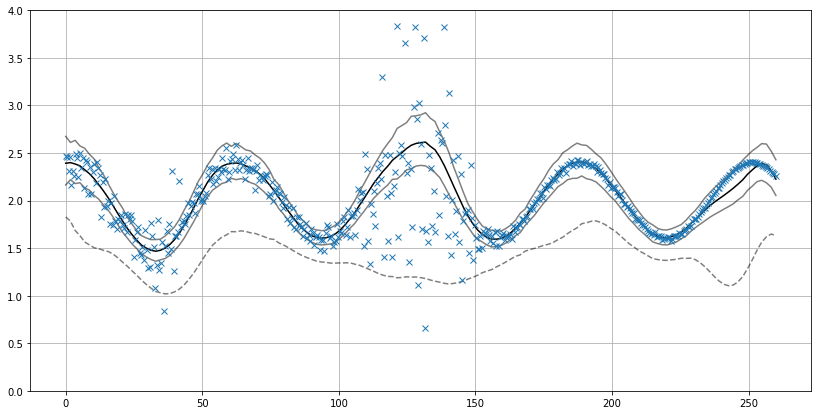

In [45]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,260,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/(1+qf_mu[:151,0]),'k-')
    
    plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]-2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)

    plt.plot(X[:,0],Y[:,1]/Y[:,0],'x')
    plt.ylim([0,4])
    plt.grid()

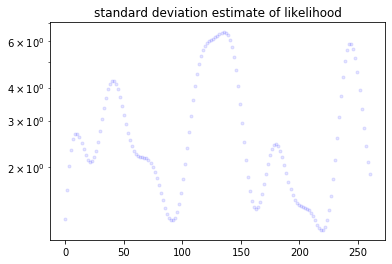

In [46]:
plt.title('standard deviation estimate of likelihood')
plt.plot(x,np.sqrt(np.exp(sampslike[:,:,0].numpy().T)),'b.',alpha=0.1);
plt.gca().set_yscale('log')
#plt.ylim([1e-3,1])

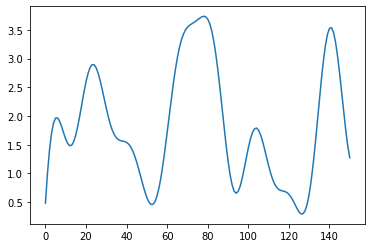

In [47]:
plt.plot(qf_mulike.numpy())

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [61]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [66]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]
    #return 100*samps[:,:,0:1] + Y*tf.exp(samps[:,:,1:2])

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.001,lr=0.05)
elbo_record = cs.run(its=2000)

Starting Run
20 (ELBO=3494100224.0000)
40 (ELBO=651303808.0000)
60 (ELBO=341075520.0000)
80 (ELBO=249751152.0000)
100 (ELBO=217985424.0000)
120 (ELBO=193495264.0000)
140 (ELBO=178487008.0000)
160 (ELBO=152217696.0000)
180 (ELBO=141738032.0000)
200 (ELBO=123898568.0000)
220 (ELBO=103514216.0000)
240 (ELBO=92822336.0000)
260 (ELBO=90713712.0000)
280 (ELBO=76355688.0000)
300 (ELBO=66193820.0000)
320 (ELBO=57252260.0000)
340 (ELBO=56511980.0000)
360 (ELBO=50221736.0000)
380 (ELBO=47177600.0000)
400 (ELBO=44767148.0000)
420 (ELBO=44255680.0000)
440 (ELBO=41876124.0000)
460 (ELBO=39499636.0000)
480 (ELBO=38449464.0000)
500 (ELBO=38811928.0000)
520 (ELBO=39877520.0000)
540 (ELBO=37030732.0000)
560 (ELBO=38832456.0000)
580 (ELBO=39301884.0000)
600 (ELBO=38902260.0000)
620 (ELBO=37940080.0000)
640 (ELBO=38100516.0000)
660 (ELBO=37680860.0000)
680 (ELBO=39873216.0000)
700 (ELBO=37204072.0000)
720 (ELBO=36123876.0000)
740 (ELBO=38732392.0000)
760 (ELBO=35351436.0000)
780 (ELBO=38059196.0000)
800 

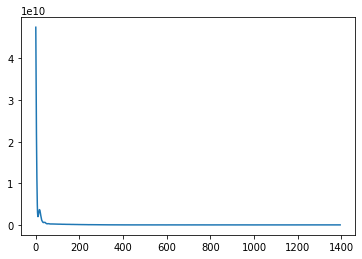

In [67]:
plt.plot(elbo_record)
#plt.ylim([0,300000000])

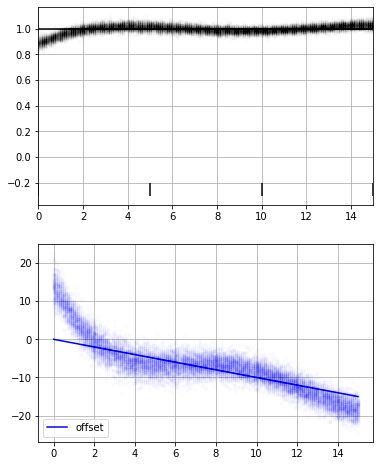

In [71]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,8])
    plt.subplot(2,1,1)
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.hlines(1,0,15,'k',label='scale')
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    #plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.subplot(2,1,2)
    plt.grid()
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    plt.legend(loc='lower left')

# Passing on the calibration

In [72]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
X = 1.0*np.array([[0,0,1],
              [1,0,2],
              [2,0,1],
              [3,0,2],
              [4,0,1],
              [5,0,2],
              [6,0,1],
              [7,0,2],
              [8,1,3],
              [9,0,2],
             [10,1,3],
             [11,0,2],
             [12,1,3],
             [13,2,4],
             [14,1,3],
             [15,2,4],
             [16,1,3],
             [17,2,4],
             [18,3,5],
             [19,2,4],
             [20,3,5],
             [21,4,5],
             [22,3,5],
             [23,4,5],
             [24,3,5],
             [30,0,5],
             [32,0,5],
             [34,0,5]])
N = len(X)
Y = np.c_[(3.0+X[:,1])*10,(3.0+X[:,2])*10]+np.random.randn(N,2)*0.1
refsensor = np.array([1,0,0,0,0,0])
Z = np.linspace(0,35,7)[:,None]

In [74]:
np.c_[X,Y]

array([[ 0.        ,  0.        ,  1.        , 30.05749484, 39.94170164],
       [ 1.        ,  0.        ,  2.        , 30.04685079, 50.14875811],
       [ 2.        ,  0.        ,  1.        , 30.20309916, 39.87709336],
       [ 3.        ,  0.        ,  2.        , 29.95918026, 49.97671214],
       [ 4.        ,  0.        ,  1.        , 29.9812573 , 39.95289069],
       [ 5.        ,  0.        ,  2.        , 29.9057595 , 49.85664073],
       [ 6.        ,  0.        ,  1.        , 29.88752464, 39.99493726],
       [ 7.        ,  0.        ,  2.        , 30.04991134, 49.94880416],
       [ 8.        ,  1.        ,  3.        , 39.89455092, 60.002281  ],
       [ 9.        ,  0.        ,  2.        , 30.01662576, 49.84253794],
       [10.        ,  1.        ,  3.        , 39.91928862, 60.09474853],
       [11.        ,  0.        ,  2.        , 29.77555695, 49.89317097],
       [12.        ,  1.        ,  3.        , 39.95591184, 59.97336861],
       [13.        ,  2.        ,  4. 

In [78]:
def transform_fn(samps,Y):
    return Y*tf.exp(samps[:,:,0:1])
k = gpflow.kernels.RBF(1.0,20)+gpflow.kernels.Bias(2.0)
cs = CalibrationSystemNoMiniBatch(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=0.2,lr=0.01)
import time
before = time.time()
elbo_record = cs.run(2000)
print(time.time()-before)

Starting Run
20 (ELBO=86631.5938)
40 (ELBO=41764.6016)
60 (ELBO=25286.8438)
80 (ELBO=17781.5059)
100 (ELBO=13405.3906)
120 (ELBO=10437.4238)
140 (ELBO=8387.3369)
160 (ELBO=6838.1084)
180 (ELBO=5776.1787)
200 (ELBO=4900.4629)
220 (ELBO=4159.9175)
240 (ELBO=3692.0913)
260 (ELBO=3354.5591)
280 (ELBO=2963.8140)
300 (ELBO=2754.6982)
320 (ELBO=2552.5576)
340 (ELBO=2305.6650)
360 (ELBO=2169.2871)
380 (ELBO=2069.7825)
400 (ELBO=1936.8096)
420 (ELBO=1825.3448)
440 (ELBO=1765.3169)
460 (ELBO=1650.6755)
480 (ELBO=1571.9814)
500 (ELBO=1536.6940)
520 (ELBO=1454.2935)
540 (ELBO=1389.0459)
560 (ELBO=1341.3103)
580 (ELBO=1270.5688)
600 (ELBO=1204.0784)
620 (ELBO=1153.2283)
640 (ELBO=1141.5476)
660 (ELBO=1092.6040)
680 (ELBO=1075.0753)
700 (ELBO=1001.8832)
720 (ELBO=995.8341)
740 (ELBO=956.2307)
760 (ELBO=947.4099)
780 (ELBO=893.6361)
800 (ELBO=874.5185)
820 (ELBO=831.1264)
840 (ELBO=807.5132)
860 (ELBO=790.2754)
880 (ELBO=765.9707)
900 (ELBO=726.2059)
920 (ELBO=723.5829)
940 (ELBO=687.1149)
960 (ELBO=

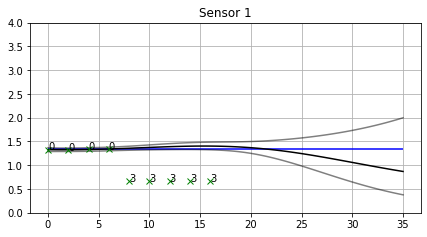

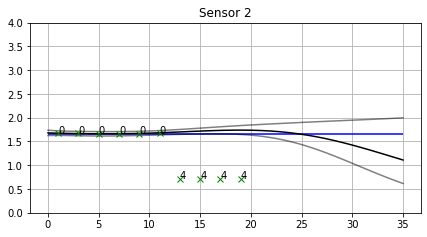

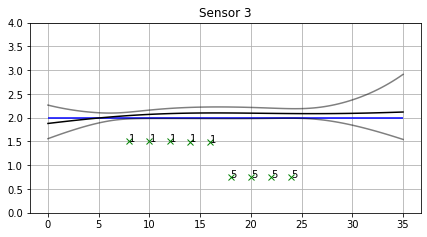

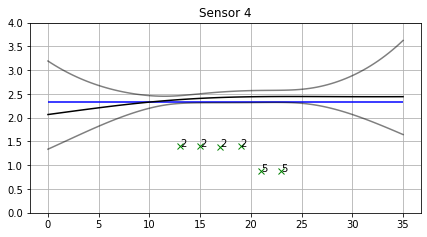

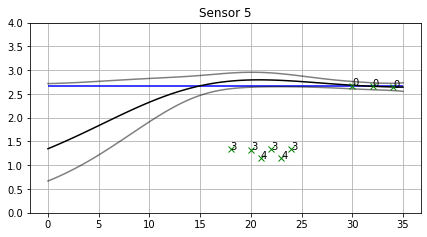

In [82]:
C = 1
Ttotal = 35
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,100)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[7,3.5])
    #plt.plot(x,1/(1+qf_mu[:,0]),'k-')
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-')
    #plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    #r = (1/(1+(qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:])))).numpy()
    #r[r<0] = np.nan
    #plt.plot(x,r,'k-',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[0]/y[1],"%d" % x[2])
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[1]/y[0],"%d" % x[1])
    plt.hlines((3.0+si)/3.0,0,35,'b')
    plt.ylim([0,4])
    #plt.ylim([0.5,10])
    #plt.yscale('log')
    plt.grid()
    plt.title("Sensor %d"  % si)